In [100]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
%cd /content/drive/My Drive/MLA4H/project/notebook

/content/drive/My Drive/MLA4H/project_final/notebook


In [103]:
!pip install -q catboost shap "dask[dataframe]"

In [104]:
# Import libraries
import os
import json
import pandas as pd
import numpy as np

import shap

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# 1. Read Processed CSV

In [80]:
df = pd.read_csv('../data/processed_Ost_LabEvents.csv')

df.tail(5)

,gender,anchor_age,CCR,CCR>0.2,PTH,PTH>65,Osteoporosis
49742,0,66,0.233028,1,58.428571,0,0
49743,0,91,0.044726,0,61.500000,0,0
49744,0,91,0.056184,0,61.500000,0,0
49745,0,64,0.106355,0,61.500000,0,0
49746,1,69,0.053807,0,61.500000,0,0


In [81]:
df['Osteoporosis'].value_counts()

,count
Osteoporosis,
0,46779
1,2968


# 2. Model Training & Evaluation

In [82]:
def cross_validate_model(df, target_column, model, param_grid, sample_size=0.1, test_size=0.2, random_state=90089):
    """
    Perform cross-validation with hyperparameter tuning and SMOTE on a 10% sample of the dataset.

    Parameters:
    - df: pd.DataFrame, the input dataset.
    - target_column: str, the target column in the dataframe.
    - model: Estimator, the machine learning model to be used.
    - param_grid: dict, hyperparameter grid for GridSearchCV.
    - sample_size: float, the fraction of data to be used for cross-validation (e.g., 0.1 for 10%).
    - test_size: float, fraction of data to use for testing.
    - random_state: int, random seed for reproducibility.

    Returns:
    - best_pipeline: The best estimator pipeline from grid search.
    - best_params: The best parameters from grid search.
    """

    # Step 1: Take a 10% random sample of the dataset
    df_sample = df.sample(frac=sample_size, random_state=random_state)

    # Step 2: Split features and target for sampled data
    X_sample = df_sample.drop(columns=[target_column])
    y_sample = df_sample[target_column]

    # Step 3: Split the sampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=test_size, random_state=random_state)

    # Step 4: Create a pipeline with StandardScaler, SMOTE, and the model
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=random_state)),
        ('model', model)
    ])

    # Step 5: Initialize Grid Search with Cross-Validation on the sampled data
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='average_precision', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Return the best estimator and best parameters
    print("\nBest Hyperparameters:", grid_search.best_params_)
    print("Best Cross-Validation avg precision Score:", grid_search.best_score_)
    return grid_search.best_estimator_, grid_search.best_params_


# Step 2: Final evaluation function
def evaluate_model(best_pipeline, df, target_column, test_size=0.2, random_state=90089):
    """
    Evaluate the best model on the test set and print evaluation metrics.

    Parameters:
    - best_pipeline: The best estimator pipeline from cross-validation.
    - df: pd.DataFrame, the input dataset.
    - target_column: str, the target column in the dataframe.
    - test_size: float, fraction of data to use for testing.
    - random_state: int, random seed for reproducibility.

    Returns:
    - Feature names and feature weights (if applicable).
    """

    # Split features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Predict and evaluate on the test set
    y_pred = best_pipeline.predict(X_test)
    y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

    # Print evaluation metrics
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nTest ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("\nAverage Precision Score:", average_precision_score(y_test, y_pred_proba))

    # Extract and preprocess the features for SHAP
    preprocessor = best_pipeline.named_steps['scaler']
    model = best_pipeline.named_steps['model']
    X_test_transformed = preprocessor.transform(X_test)

    # Optimize background data sampling for KernelExplainer (use 100 samples)
    X_train_summary = shap.sample(X_train, 100, random_state=random_state)

    # Choose the SHAP explainer based on the model type
    explainer = None
    if hasattr(model, 'feature_importances_') and "tree" in str(type(model)).lower():  # Tree-based models
        explainer = shap.TreeExplainer(model)
    elif hasattr(model, 'coef_'):  # Linear models like Logistic Regression
        explainer = shap.LinearExplainer(model, X_test_transformed)
    else:  # Use KernelExplainer as a fallback with wrapped model
        explainer = shap.KernelExplainer(lambda x: model.predict(x), X_train_summary)

    # Calculate SHAP values on a subset of X_test for efficiency
    X_test_subset = shap.sample(X_test_transformed, 1000, random_state=random_state)
    shap_values = explainer.shap_values(X_test_subset)

    # Calculate mean absolute SHAP values for feature importance, ensuring a single scalar per feature
    if isinstance(shap_values, list):  # Multi-output case
        shap_importance = np.mean([np.abs(vals).mean(axis=0) for vals in shap_values], axis=0)
    else:
        shap_importance = np.abs(shap_values).mean(axis=0)

    # Ensure shap_importance is 1D array of scalars, then print feature importances
    shap_importance = shap_importance.flatten()
    feature_names = X_test.columns
    print("\nFeature Importances (SHAP):")
    for name, importance in zip(feature_names, shap_importance):
        print(f"{name}: {importance:.4f}")

    return feature_names, shap_importance


# 3. Predict Osteoporosis with ML Models

In [83]:
target_column = 'Osteoporosis'
feature_weights_dict = dict()

In [84]:
# df=df.sample(frac=0.5)

In [85]:
# Define the LogisticRegression model and parameter grid
model = LogisticRegression(max_iter=500)
param_grid = {
    'model__C': [0.001],
    'model__solver': ['liblinear']
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_lr = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["LogisticRegression"] = feature_weights_lr

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {'model__C': 0.001, 'model__solver': 'liblinear'}
Best Cross-Validation avg precision Score: 0.19221497312424213

Confusion Matrix:
 [[6057 3283]
 [ 114  496]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.65      0.78      9340
           1       0.13      0.81      0.23       610

    accuracy                           0.66      9950
   macro avg       0.56      0.73      0.50      9950
weighted avg       0.93      0.66      0.75      9950


Test ROC-AUC Score: 0.7972708603924596

Average Precision Score: 0.18895705845957428

Feature Importances (SHAP):
gender: 0.3955
anchor_age: 0.3921
CCR: 0.0624
CCR>0.2: 0.0149
PTH: 0.0201
PTH>65: 0.0855


In [86]:
# Define the SVC model and parameter grid
model = SVC(probability=True)
param_grid = {
    'model__C': [0.1],
    'model__kernel': ['rbf'],
    'model__gamma': ['auto']
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# # Step 2: Final evaluation on the test set
feature_names, feature_weights_svm = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["SVC"] = feature_weights_svm

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {'model__C': 0.1, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best Cross-Validation avg precision Score: 0.17944310380441655

Confusion Matrix:
 [[6100 3240]
 [  97  513]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.65      0.79      9340
           1       0.14      0.84      0.24       610

    accuracy                           0.66      9950
   macro avg       0.56      0.75      0.51      9950
weighted avg       0.93      0.66      0.75      9950


Test ROC-AUC Score: 0.8071905606065926

Average Precision Score: 0.1962530821054661


  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.1027
anchor_age: 0.1670
CCR: 0.0035
CCR>0.2: 0.0011
PTH: 0.1670
PTH>65: 0.0217


In [87]:
# Define the GaussianNB model and parameter grid
model = GaussianNB()
# No hyperparameters to tune for GaussianNB
param_grid = {}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_nb = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["GaussianNB"] = feature_weights_nb

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {}
Best Cross-Validation avg precision Score: 0.16481864109215583

Confusion Matrix:
 [[6781 2559]
 [ 160  450]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.73      0.83      9340
           1       0.15      0.74      0.25       610

    accuracy                           0.73      9950
   macro avg       0.56      0.73      0.54      9950
weighted avg       0.93      0.73      0.80      9950


Test ROC-AUC Score: 0.7737632955383158

Average Precision Score: 0.15849144620526828


  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.0905
anchor_age: 0.1330
CCR: 0.0052
CCR>0.2: 0.0004
PTH: 0.1330
PTH>65: 0.0081


In [88]:
# Define the KNeighbors model and parameter grid
model = KNeighborsClassifier()
param_grid = {
    'model__n_neighbors': [10],
    'model__weights': ['uniform' ]
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_knn = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["KNeighbors"] = feature_weights_knn

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {'model__n_neighbors': 10, 'model__weights': 'uniform'}
Best Cross-Validation avg precision Score: 0.13076488509224554

Confusion Matrix:
 [[7419 1921]
 [ 194  416]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.88      9340
           1       0.18      0.68      0.28       610

    accuracy                           0.79      9950
   macro avg       0.58      0.74      0.58      9950
weighted avg       0.93      0.79      0.84      9950


Test ROC-AUC Score: 0.7968224979815354

Average Precision Score: 0.2607886120938982


  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.0707
anchor_age: 0.1136
CCR: 0.0722
CCR>0.2: 0.0006
PTH: 0.1689
PTH>65: 0.0226


In [89]:
# Define the DecisionTree model and parameter grid
model = DecisionTreeClassifier()
param_grid = {
    'model__max_depth': [5],
    'model__min_samples_split': [5]
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_tree = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["DecisionTree"] = feature_weights_tree

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {'model__max_depth': 5, 'model__min_samples_split': 5}
Best Cross-Validation avg precision Score: 0.17674540591546137

Confusion Matrix:
 [[7019 2321]
 [ 182  428]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.75      0.85      9340
           1       0.16      0.70      0.25       610

    accuracy                           0.75      9950
   macro avg       0.57      0.73      0.55      9950
weighted avg       0.92      0.75      0.81      9950


Test ROC-AUC Score: 0.7901989503984275

Average Precision Score: 0.18208958097588737

Feature Importances (SHAP):
gender: 0.1418
anchor_age: 0.1418
CCR: 0.1706
CCR>0.2: 0.1706
PTH: 0.0275
PTH>65: 0.0275


In [90]:

# Define the RandomForest model and parameter grid
model = RandomForestClassifier()
param_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [5],
    'model__min_samples_split': [5],
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_rf = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["RandomForest"] = feature_weights_rf

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Cross-Validation avg precision Score: 0.24025151228705383

Confusion Matrix:
 [[6459 2881]
 [ 112  498]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81      9340
           1       0.15      0.82      0.25       610

    accuracy                           0.70      9950
   macro avg       0.57      0.75      0.53      9950
weighted avg       0.93      0.70      0.78      9950


Test ROC-AUC Score: 0.8213833503001369

Average Precision Score: 0.22680045959323625


  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.3697
anchor_age: 0.3224
CCR: 0.0956
CCR>0.2: 0.0002
PTH: 0.1561
PTH>65: 0.0171


In [91]:
# Define the AdaBoost model and parameter grid
model = AdaBoostClassifier()
param_grid = {
    'model__n_estimators': [50],
    'model__learning_rate': [0.1]
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_adaboost = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["AdaBoost"] = feature_weights_adaboost

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Best Hyperparameters: {'model__learning_rate': 0.1, 'model__n_estimators': 50}
Best Cross-Validation avg precision Score: 0.22482724877619384

Confusion Matrix:
 [[6230 3110]
 [ 110  500]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.79      9340
           1       0.14      0.82      0.24       610

    accuracy                           0.68      9950
   macro avg       0.56      0.74      0.52      9950
weighted avg       0.93      0.68      0.76      9950


Test ROC-AUC Score: 0.8085034401656896

Average Precision Score: 0.2087092567118862


  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.4023
anchor_age: 0.2663
CCR: 0.0000
CCR>0.2: 0.0000
PTH: 0.0260
PTH>65: 0.0000


In [92]:
# Define the XGB model and parameter grid
model = XGBClassifier()
param_grid = {
    'model__n_estimators': [100],
    'model__learning_rate': [0.01],
    'model__max_depth': [5]
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_xgb = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["XGB"] = feature_weights_xgb

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 100}
Best Cross-Validation avg precision Score: 0.23043796993407484

Confusion Matrix:
 [[6565 2775]
 [ 119  491]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.70      0.82      9340
           1       0.15      0.80      0.25       610

    accuracy                           0.71      9950
   macro avg       0.57      0.75      0.54      9950
weighted avg       0.93      0.71      0.78      9950


Test ROC-AUC Score: 0.8108464387264367

Average Precision Score: 0.21154214694123166


  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.3577
anchor_age: 0.3015
CCR: 0.0095
CCR>0.2: 0.0000
PTH: 0.0912
PTH>65: 0.0000


In [93]:
# Define the LGBM model and parameter grid
model = LGBMClassifier()
param_grid = {
    'model__n_estimators': [150],
    'model__learning_rate': [0.01],
    'model__num_leaves': [5]
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_lgb = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["LGBM"] = feature_weights_lgb

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 3736, number of negative: 3736
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 799
[LightGBM] [Info] Number of data points in the train set: 7472, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Best Hyperparameters: {'model__learning_rate': 0.01, 'model__n_estimators': 150, 'model__num_leaves': 5}
Best Cross-Validation avg precision Score: 0.2218053768576033

Confusion Matrix:
 [[6725 2615]
 [ 137  473]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83      9340
           1       0.15      0.78      0.26       610

    accuracy                           

  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.4030
anchor_age: 0.2860
CCR: 0.0000
CCR>0.2: 0.0000
PTH: 0.0287
PTH>65: 0.0000


In [94]:
# Define the CatBoost model and parameter grid
model = CatBoostClassifier(verbose=0)  # Suppress CatBoost output
param_grid = {
    'model__iterations': [100],
    'model__learning_rate': [0.01]
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_cat = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["CatBoost"] = feature_weights_cat

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {'model__iterations': 100, 'model__learning_rate': 0.01}
Best Cross-Validation avg precision Score: 0.23805902790133246

Confusion Matrix:
 [[6603 2737]
 [ 120  490]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82      9340
           1       0.15      0.80      0.26       610

    accuracy                           0.71      9950
   macro avg       0.57      0.76      0.54      9950
weighted avg       0.93      0.71      0.79      9950


Test ROC-AUC Score: 0.8189837469723031

Average Precision Score: 0.22641961659000714


  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.3733
anchor_age: 0.2466
CCR: 0.0077
CCR>0.2: 0.0000
PTH: 0.0691
PTH>65: 0.0359


In [95]:
# Define the MLP model and parameter grid
model = MLPClassifier(max_iter=500)
param_grid = {
    'model__hidden_layer_sizes': [(50,)],
    'model__activation': ['relu'],
    'model__alpha': [0.001],
    'model__learning_rate': ['adaptive']
}

# Step 1: Cross-validation
best_pipeline, best_params = cross_validate_model(df, target_column, model, param_grid)

# Step 2: Final evaluation on the test set
feature_names, feature_weights_mlp = evaluate_model(best_pipeline, df, target_column)

feature_weights_dict["MLP"] = feature_weights_mlp

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Hyperparameters: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50,), 'model__learning_rate': 'adaptive'}
Best Cross-Validation avg precision Score: 0.18849208335627235

Confusion Matrix:
 [[6756 2584]
 [ 125  485]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83      9340
           1       0.16      0.80      0.26       610

    accuracy                           0.73      9950
   macro avg       0.57      0.76      0.55      9950
weighted avg       0.93      0.73      0.80      9950


Test ROC-AUC Score: 0.8100742443921788

Average Precision Score: 0.21313627257781956


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]


Feature Importances (SHAP):
gender: 0.0817
anchor_age: 0.1153
CCR: 0.0203
CCR>0.2: 0.0039
PTH: 0.1153
PTH>65: 0.0442


In [96]:
data = {k: [float(x) for x in v] for k, v in feature_weights_dict.items()}

with open("../model/ost_feature_importance.json", 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, indent=4)

# 4. Plot the Feature Importance

In [105]:
# Loading data from a JSON file
with open('../model/ost_feature_importance.json', 'r') as json_file:
    data = json.load(json_file)

In [108]:
def transform(weights):
    # Apply absolute value to each integer
    absolute_values = [abs(i) for i in weights]

    # Calculate the sum of absolute values
    total_sum = sum(absolute_values)

    # Transform each integer by dividing by the sum of absolute values
    return [i / total_sum for i in absolute_values]

def plot_feature_importance(data, feature_names, target_column):
    """
    Plot feature importances for multiple models in an academic style with a horizontal layout.

    Parameters:
    - data: dict, where keys are model names and values are lists of feature weights.
    - feature_names: list of str, names of features corresponding to the weights.
    - target_column: str, the target column or label for the plot title.
    """
    # Normalize feature weights for each model in the data
    scaled_data = {model: transform(weights) for model, weights in data.items()}

    # Create a combined list with feature names and the normalized weights for each model
    combined = list(zip(feature_names, *[scaled_data[model] for model in data.keys()]))

    # Sort combined list by the total weight across all models (sum of weights)
    sorted_combined = sorted(combined, key=lambda x: sum(x[1:]), reverse=True)

    # Unzip the sorted list back into separate lists for plotting
    sorted_feature_names = [x[0] for x in sorted_combined]
    sorted_weights = [x[1:] for x in sorted_combined]

    # Number of features and models
    num_features = len(feature_names)
    num_models = len(data)

    # Define bar width for side-by-side plotting based on the number of models
    bar_width = 0.7 / num_models  # Adjust width to fit all models

    # Use a colorful palette from Seaborn
    colors = sns.color_palette("husl", num_models)  # 'husl' gives highly distinguishable colors

    # Plotting setup with academic styling
    plt.figure(figsize=(12, 6))  # Adjusted to be wider and shorter
    indices = np.arange(num_features)

    # Plot each model's weights with distinct colors
    for i, (model_name, color) in enumerate(zip(data.keys(), colors)):
        weights = [weight[i] for weight in sorted_weights]
        plt.barh(
            indices - (num_models / 2 - i) * bar_width,
            weights,
            height=bar_width,
            color=color,
            edgecolor='black',
            align='center',
            label=model_name
        )

    # Customize the plot appearance for a professional look
    plt.yticks(indices, sorted_feature_names, fontsize=12)
    plt.xlabel("Normalized Feature Importance", fontsize=14, labelpad=15)
    plt.title(f"Feature Importance Comparison for {target_column}", fontsize=16, fontweight='bold', pad=15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Models", fontsize=12, title_fontsize=12, frameon=False)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance on top
    plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))  # Display x-axis as percentages

    # Tidy layout and save as high-resolution PNG
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.savefig("../plot/ost_feature_importance.png", dpi=600)  # Increase DPI for higher resolution

    # Display the plot
    plt.show()


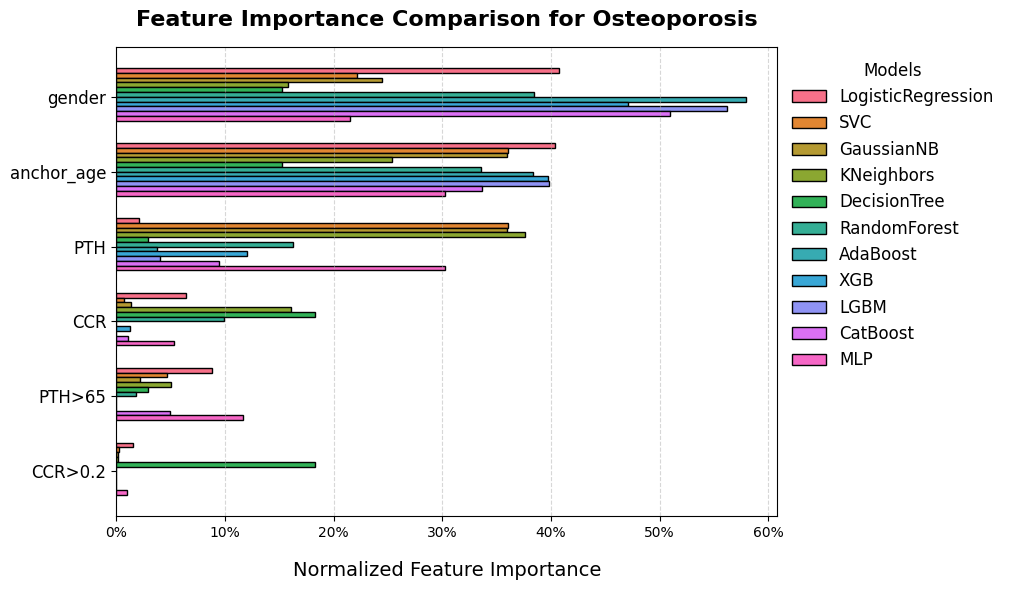

In [109]:
plot_feature_importance(data, df.columns[:-1], target_column)